In [ ]:
from IPython.display import Image

목차


* 생성적 적대 신경망 소개
    * 오토인코더
    * 새로운 데이터 합성을 위한 생성 모델
    * GAN으로 새로운 샘플 생성
    * GAN의 생성자와 판별자 손실 함수 이해

* 밑바닥부터 GAN 모델 구현
    * 구글 코랩에서 GAN 모델 훈련
    * 생성자와 판별자 신경망 구현
    * 훈련 데이터셋 정의
    * GAN 모델 훈련하기

In [ ]:
# 오토 인코더
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_01.png', width=400)

In [ ]:
# 새로운 데이터 합성을 위한 생성모델
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_02.png', width=700)

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_03.png', width=700)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 생성자 함수 정의
def make_generator_network(
    input_size=20, num_hidden_layers = 1, num_hidden_units=100,num_output_units=784
):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units) )
    model.add_module(f'relu_g{i}', nn.LeakyReLU())
    input_size = num_hidden_units
  model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units) )
  model.add_module('tanh_g', nn.Tanh())
  return model

def make_discriminator_network(
    input_size, num_hidden_layers = 1, num_hidden_units=100,num_output_units=1
):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False) )
    model.add_module(f'relu_d{i}', nn.LeakyReLU())
    model.add_module('dropout', nn.Dropout(p=0.5))
    input_size = num_hidden_units
  model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units) )
  model.add_module('sigmoid', nn.Sigmoid())
  return model

In [ ]:
image_size = (28,28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)

params = {
    'input_size':z_size,'num_hidden_layers':gen_hidden_layers,
    'num_hidden_units':gen_hidden_size,'num_output_units':np.prod(image_size)
}

gen_model = make_generator_network(**params)
gen_model

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)

In [ ]:
params={
    'input_size':np.prod(image_size), 'num_hidden_layers':disc_hidden_layers,
    'num_hidden_units':disc_hidden_size
}
disc_model = make_discriminator_network(**params)
disc_model

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# 훈련 데이터 셋 정의
import torchvision
from torchvision import transforms

In [ ]:
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train=True, transform = transform,download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145003056.07it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 18824505.64it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46287079.41it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20550732.22it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
example, label =  next(iter(mnist_dataset))
print(f'최소 : {example.min()} 최대:{example.max()}')
print(example.shape)

최소 : -1.0 최대:1.0
torch.Size([1, 28, 28])


In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size)*2 - 1
  elif mode_z =='normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

In [ ]:
from torch.utils.data import DataLoader
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=True)
input_real, label =  next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)
mode_z = 'uniform'
input_z  = create_noise(batch_size, z_size, mode_z)

print('input-z -- 크기:',input_z.shape)
print('input-real -- 크기:',input_real.shape)

g_output = gen_model(input_z)
print('생성자 출력 -- 크기:',g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('판별자(진짜)--크기:',d_proba_real.shape)
print('판별자(가짜)--크기:',d_proba_fake.shape)

input-z -- 크기: torch.Size([32, 20])
input-real -- 크기: torch.Size([32, 784])
생성자 출력 -- 크기: torch.Size([32, 784])
판별자(진짜)--크기: torch.Size([32, 1])
판별자(가짜)--크기: torch.Size([32, 1])


GAN 모델 훈련하기

In [ ]:
loss_fn = nn.BCELoss()
# 생성자 손실
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss:{g_loss:.4f}')

# 판별자 손실
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real,d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f"판별자 손실:진짜{d_loss_real:.4f} 가짜{d_loss_fake:.4f}")

Generator Loss:0.6983
판별자 손실:진짜0.7487 가짜0.6885


In [ ]:
# 최종훈련
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

#데이터셋 생성
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#모델 생성
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)
# 손실함수와 옵티마이져
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [ ]:
# 판별자 훈련
def d_train(x):
  disc_model.zero_grad()
  # 진짜 배치에서 판별자 훈련
  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)

  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # 가짜 배치에서 판별자 훈련
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)

  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # 그레이디언트 역전파와 판별자 파라미터 최적화
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()

  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
# 생성자 훈련
def g_train(x):
  gen_model.zero_grad()

  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size,1,device=device)

  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)
  # 그레이디언트 역전파와 생성자 파라미터 최적화
  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'에포크 {epoch:03d} | 평균 손실 >>'
          f' 생성자/판별자 {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [판별자-진짜: {all_d_real[-1]:.4f} 판별자-가짜: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 평균 손실 >> 생성자/판별자 0.8944/0.9068 [판별자-진짜: 0.8035 판별자-가짜: 0.4717]
에포크 002 | 평균 손실 >> 생성자/판별자 0.9469/1.1271 [판별자-진짜: 0.6164 판별자-가짜: 0.4318]
에포크 003 | 평균 손실 >> 생성자/판별자 0.9596/1.1998 [판별자-진짜: 0.5790 판별자-가짜: 0.4277]
에포크 004 | 평균 손실 >> 생성자/판별자 0.9415/1.2163 [판별자-진짜: 0.5737 판별자-가짜: 0.4305]
에포크 005 | 평균 손실 >> 생성자/판별자 0.9270/1.2284 [판별자-진짜: 0.5705 판별자-가짜: 0.4286]
에포크 006 | 평균 손실 >> 생성자/판별자 0.9453/1.2473 [판별자-진짜: 0.5620 판별자-가짜: 0.4335]
에포크 007 | 평균 손실 >> 생성자/판별자 1.0020/1.1734 [판별자-진짜: 0.5897 판별자-가짜: 0.4058]
에포크 008 | 평균 손실 >> 생성자/판별자 1.0015/1.1883 [판별자-진짜: 0.5890 판별자-가짜: 0.4110]
에포크 009 | 평균 손실 >> 생성자/판별자 0.9548/1.2096 [판별자-진짜: 0.5805 판별자-가짜: 0.4229]
에포크 010 | 평균 손실 >> 생성자/판별자 0.9074/1.2498 [판별자-진짜: 0.5619 판별자-가짜: 0.4359]
에포크 011 | 평균 손실 >> 생성자/판별자 0.9841/1.2001 [판별자-진짜: 0.5831 판별자-가짜: 0.4135]
에포크 012 | 평균 손실 >> 생성자/판별자 0.9437/1.2165 [판별자-진짜: 0.5803 판별자-가짜: 0.4267]
에포크 013 | 평균 손실 >> 생성자/판별자 0.9947/1.1981 [판별자-진짜: 0.5860 판별자-가짜: 0.4148]
에포크 014 | 평균 손실 >> 생성자/판별자 0.9812/1.2052 [판별자-진짜: 0

In [ ]:
# 시각화를 위해서 수집한 변수를 저장하고 불러오기
saved_variables = {
    'epoch_samples': epoch_samples,
    'all_d_losses': all_d_losses,
    'all_g_losses': all_g_losses,
    'all_d_real': all_d_real,
    'all_d_fake': all_d_fake
}
torch.save(saved_variables,'/content/drive/MyDrive/saved_variables,pth')


# 판별자 모델
torch.save(disc_model,'/content/drive/MyDrive/disc_model.pth')
 # 생성자 모델
torch.save(gen_model,'/content/drive/MyDrive/gen_model.pth')


In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device : {device}")

# 불러오기
loaded_variables = torch.load('/content/drive/MyDrive/saved_variables,pth')
# 각 변수를 불러오기
epoch_samples = loaded_variables['epoch_samples']
all_d_losses = loaded_variables['all_d_losses']
all_g_losses = loaded_variables['all_g_losses']
all_d_real = loaded_variables['all_d_real']
all_d_fake = loaded_variables['all_d_fake']
# 판별자 생성자 모델 불러오기
disc_model = torch.load('/content/drive/MyDrive/disc_model.pth')
gen_model = torch.load('/content/drive/MyDrive/gen_model.pth')

device : cuda


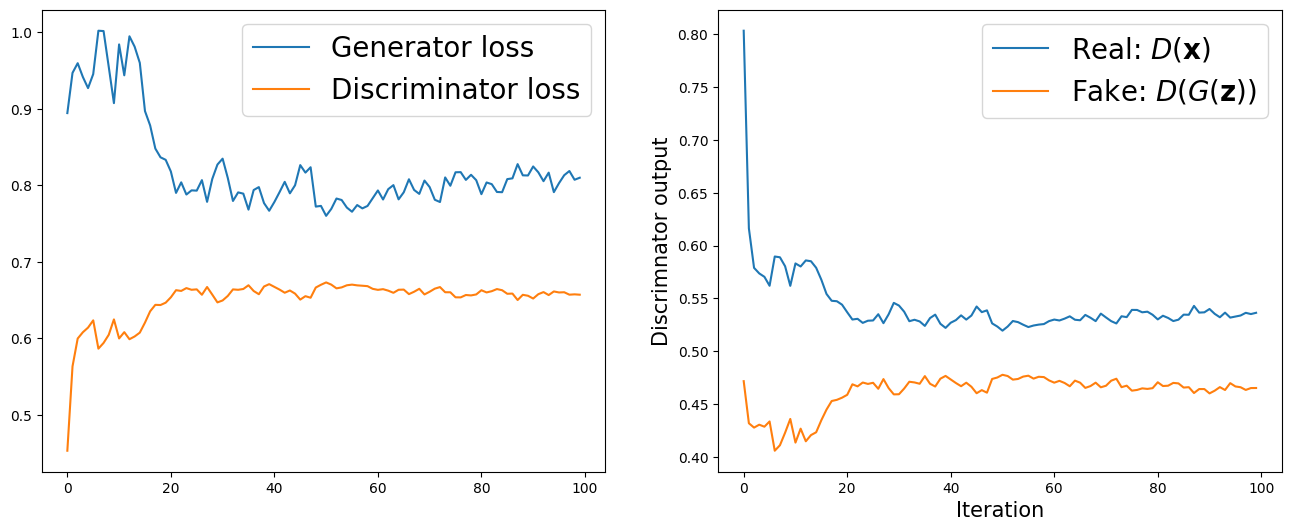

In [4]:
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(16,6))

#손실 그래프
ax = fig.add_subplot(1,2,1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2  for all_d_loss in all_d_losses ]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)

# 판별자 출력의 그래프
ax = fig.add_subplot(1,2,2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discrimnator output', size=15)
plt.show()

In [12]:
import numpy as np
np.array(epoch_samples).shape

(100, 64, 28, 28)

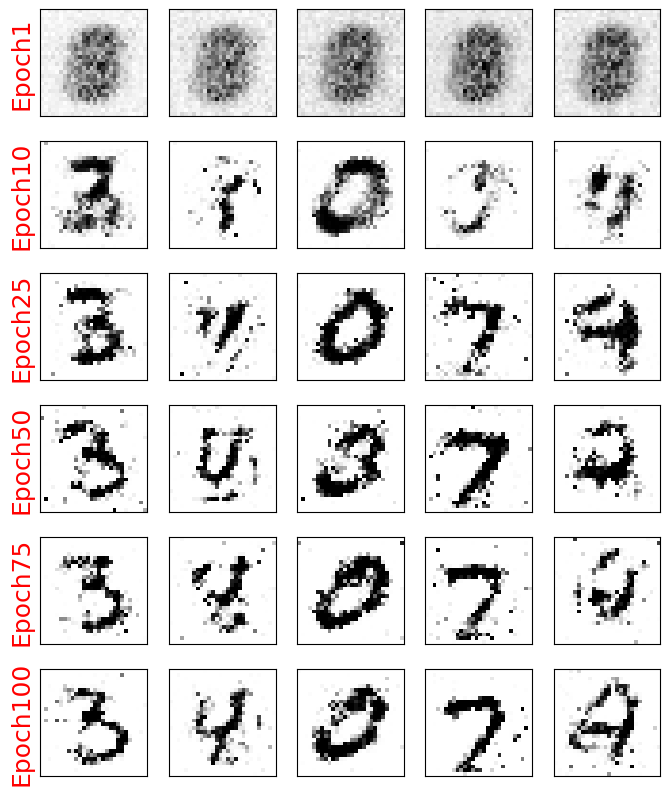

In [19]:
selected_epochs = [1,10,25,50,75,100]
fig = plt.figure(figsize=(8,10))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6,5,i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06,0.5,f'Epoch{e}', rotation=90,size=18,color='red',
          horizontalalignment = 'right',verticalalignment='center',
          transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')
plt.show()